<p style="text-align: center;" ><font size="+3"><u><b>Laboratory 4 Part 1: Optical System Modeling with Aberrations</u></b></p>

<p style="text-align: left;" ><font size="+1"><b>Group #: 13   Team Members: Jayvik Joshi, Jonathan Feng, Judy Zhou  </b></p>

<p style="text-align: left;" ><font size="+1"><b>Objectives</b></p>

<div class="alert alert-block alert-warning">
<font color=black>

- Understand and be able to model optical phase aberrations
- Build realistic models of optical systems
- Understand basic concepts of optimization 
- Identify system parameters in real data through an optimization process

</font> 
</div>

<p style="text-align: left;" ><font size="+1"><b>Introduction / Basic Rules</b></p>

<div class="alert alert-block alert-warning">
<font color='black'>

In this lab, you will extend the ideal optical model from Lab 3 to a more realistic optical system. In Part 1 of this lab, we will learn to model optical phase aberrations, and then look at how aberrations affect the PSF and the final image. <br/>
    
In Part 2, we will collect real data and apply the model you build in Part 1 to identify system parameters through an optimization process. <br/>
    
Recall from class notes and discussions that our new model of the coherent PSF is:
\begin{equation}
\large
h(u,v) = \frac{A}{\lambda z_i} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \mathcal{P}(x,y) \hspace{5px} \exp \bigg\{ -i \frac{2\pi}{\lambda z_i} (ux+vy)\bigg\} dx dy
\large
\end{equation} 
    
\begin{equation}
\large
\mathcal{P}(u,v) = \underbrace {P(u,v)}_{\text{amplitude}} \hspace{5px} \underbrace {\exp \big[ i \frac{2\pi}{\lambda} W(u,v) \big]}_{\text{phase}}
\large
\end{equation} 
    
And remember that we are adopting a generalized pupil function with two parts: amplitude and phase.
</font> 
</div>

# Generalized Pupil Function - Amplitude

<div class="alert alert-block alert-warning">
<font color=black>

Since our image is measured on the image plane (camera), it is easier for modeling purposes if we scale all the axes to the image plane. That is, we consider spatial domain and Fourier domain axes with a sampling interval based on the pixel size of the camera, 5.3 $\mu$m. <br/>

</font> 
</div>

<div class="alert alert-block alert-success">
<font color=black>

1. Specify the spatial domain and frequency domain axes ($x, y, f_x, f_y$) of a 1001 by 1001 image with sampling interval 5.3 $\mu$m. Write this code below:
</font> 
</div>

In [1]:
import numpy as np
from numpy.fft import fftshift, fftfreq, ifftshift, fft2, ifft2
import matplotlib.pyplot as plt

In [2]:
N = 1001
dx = 5.3e-6   # meters
dx_um = dx * 1e6  # microns

x = np.linspace(-((N-1)/2)*dx,((N-1)/2)*dx, N)
y = np.linspace(-((N-1)/2)*dx,((N-1)/2)*dx, N)

# Freq
fx = fftshift(fftfreq(N, dx))
fy = fftshift(fftfreq(N, dx))

<div class="alert alert-block alert-warning">
<font color=black>

If one takes the Fourier transform of both sides of the above expression for the coherent PSF, we can obtain the Fourier transform of $h$ directly. Specifically, this can be achieved by a change of axes in the pupil function.  For example, for a circular aperture of radius $r$, the amplitude of the <u> Fourier transform of $h$</u> (denoted $H$) is given by:
    
- `FX, FY = np.meshgrid(-lambd*zi*fx, -lambd*zi*fy)`. Note that `lambda` is a Python keyword reserved for anonymous function, so we will try to avoid naming a variable after it.
- `H = (FX**2 + FY**2) < r**2`
                              
`lambd` is the wavelength (e.g., 540 nm for “green” light and 600 nm for “red” light) and the `zi` is image distance (i.e., the distance from the pupil to the image plane). For now, let’s assume `zi` is 300 mm, and `r` is 2mm.
</font> 
</div>

<div class="alert alert-block alert-success">
<font color=black>

2. Simulate the PSF (recall that incoherent PSF is $|h|^2$) of the red and green light. Show the PSF and log10 PSF images below. Zoom in on the central 201 by 201 elements and use colormap `jet`. <br/>
<u> (Note: Throughout this lab, please use colormap `jet` for PSF and OTF images and colormap `gray` for all simulated object images.) </u>
</font> 
</div>

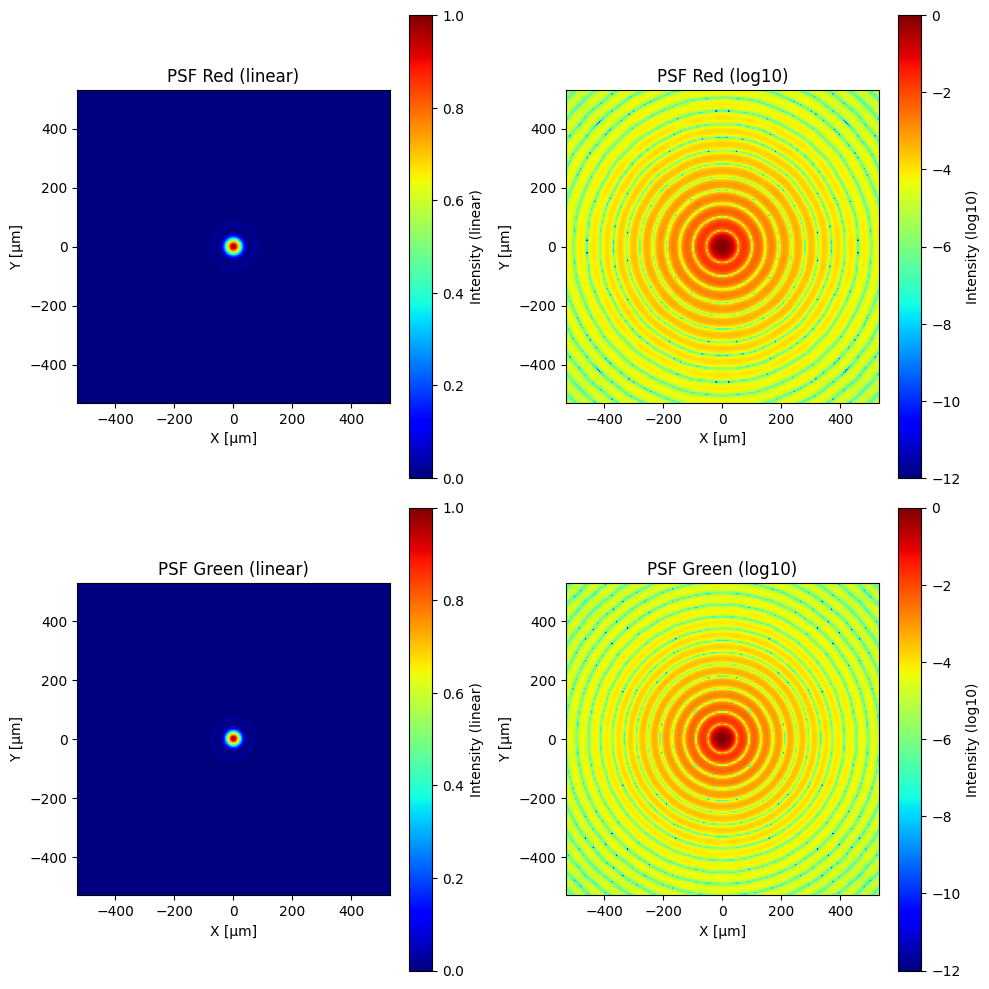

In [3]:
zi = 300e-3 # (meters)
r = 2e-3   #aperture radius (meters)

def compute_psf(lambd):
    FX, FY = np.meshgrid(-lambd * zi * fx, -lambd * zi * fy)
    
    H = (FX**2 + FY**2) < (r**2)
    h = fftshift(fft2(ifftshift(H)))
    
    psf = np.abs(h)**2

    psf /= np.max(psf) #normalize
    return psf

lambd_red = 600e-9
lambd_green = 540e-9

# Compute PSFs for both wavelengths
psf_red = compute_psf(lambd_red)
psf_green = compute_psf(lambd_green)

center = N // 2
half_zoom = 100  # since 201 = 2*100 + 1
zoom_slice = slice(center-half_zoom, center+half_zoom+1)
extent = [-half_zoom*dx_um, half_zoom*dx_um, -half_zoom*dx_um, half_zoom*dx_um]
axis_units = "µm"

graph1 = psf_red[zoom_slice, zoom_slice]
graph2 = np.log10(psf_red[zoom_slice, zoom_slice] + 1e-12)
graph3 = psf_green[zoom_slice, zoom_slice]
graph4 = np.log10(psf_green[zoom_slice, zoom_slice] + 1e-12)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

im0 = axs[0, 0].imshow(graph1, cmap='jet', extent=extent, vmin=0, vmax=1)
axs[0, 0].set_title('PSF Red (linear)')
axs[0, 0].set_xlabel(f'X [{axis_units}]')
axs[0, 0].set_ylabel(f'Y [{axis_units}]')
plt.colorbar(im0, ax=axs[0, 0], orientation='vertical', label='Intensity (linear)')

im1 = axs[0, 1].imshow(graph2, cmap='jet', extent=extent, vmin=-12, vmax=0)
axs[0, 1].set_title('PSF Red (log10)')
axs[0, 1].set_xlabel(f'X [{axis_units}]')
axs[0, 1].set_ylabel(f'Y [{axis_units}]')
plt.colorbar(im1, ax=axs[0, 1], orientation='vertical', label='Intensity (log10)')

im2 = axs[1, 0].imshow(graph3, cmap='jet', extent=extent, vmin=0, vmax=1)
axs[1, 0].set_title('PSF Green (linear)')
axs[1, 0].set_xlabel(f'X [{axis_units}]')
axs[1, 0].set_ylabel(f'Y [{axis_units}]')
plt.colorbar(im2, ax=axs[1, 0], orientation='vertical', label='Intensity (linear)')

im3 = axs[1, 1].imshow(graph4, cmap='jet', extent=extent,  vmin=-12, vmax=0)
axs[1, 1].set_title('PSF Green (log10)')
axs[1, 1].set_xlabel(f'X [{axis_units}]')
axs[1, 1].set_ylabel(f'Y [{axis_units}]')
plt.colorbar(im3, ax=axs[1, 1], orientation='vertical', label='Intensity (log10)')

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-success">
<font color=black>

3. Simulate what the star pattern looks like when the system is illuminated with red light and green light. What is the difference between the two images? How does wavelength affect the resolution of the system?
</font> 
</div>

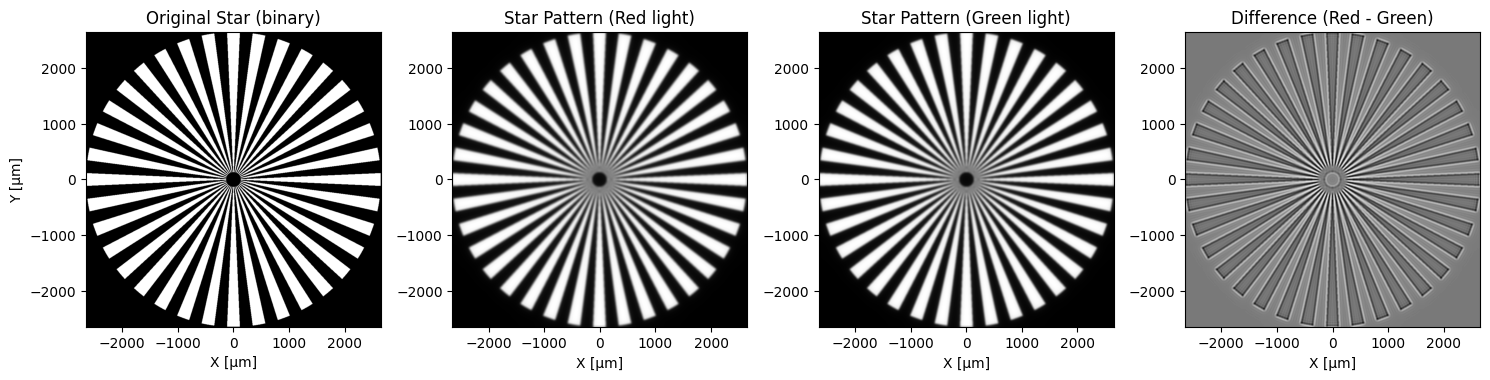

In [5]:
def make_star(x, y, stype='bin', cycles=36):
    [X,Y] = np.meshgrid(x, y)
    phy = np.arctan2(Y,X) * cycles  #phase at each pixel
    pint = np.cos(phy)  #relative intensity
    if 'bin' in stype:
        star = np.zeros_like(X, dtype=np.uint8)
        star[pint>=0] = 255
    elif 'sin' in stype:
        star = ((pint+1)*127.5).astype(np.uint8)
    mask1 = (X**2+Y**2) > (x.max()/20)**2
    mask2 = (X**2+Y**2) < (x.max())**2
    star = star.astype(np.double) * mask1.astype(np.double) * mask2.astype(np.double)
    return star/star.max()

def convolve_fft(image, psf):
    H = fft2(ifftshift(psf))
    I = fft2(image)
    result = ifft2(H * I)
    return np.real(result)

star = make_star(fx, fy, stype='bin', cycles=36)

star_red = convolve_fft(star, psf_red)
star_green = convolve_fft(star, psf_green)

# Normalize
star_red /= np.max(star_red)
star_green /= np.max(star_green)

difference = star_red - star_green

# Plot
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
extent = [x[0]*1e6, x[-1]*1e6, y[0]*1e6, y[-1]*1e6]  # in µm

axs[0].imshow(star, cmap='gray', extent=extent)
axs[0].set_title("Original Star (binary)")
axs[0].set_xlabel("X [µm]")
axs[0].set_ylabel("Y [µm]")

axs[1].imshow(star_red, cmap='gray', extent=extent)
axs[1].set_title("Star Pattern (Red light)")
axs[1].set_xlabel("X [µm]")

axs[2].imshow(star_green, cmap='gray', extent=extent)
axs[2].set_title("Star Pattern (Green light)")
axs[2].set_xlabel("X [µm]")

axs[3].imshow(difference, cmap='gray', extent=extent)
axs[3].set_title("Difference (Red - Green)")
axs[3].set_xlabel("X [µm]")

#add color bar
#long wavelength = low freq = low detail

plt.tight_layout()
plt.show()

The red light and green light images are more blurred around a disk in the center. The size of the blurry disk is dependent on the wavelength. The red light has a wavelength of 600 nm. As wavelength increases, the frequency decreases which results in lower detail and resolution. This means the green light blurry disk should be smaller, which can somewhat be seen in the images.

The difference in the red and green light images demonstrates the effect of wavelength on resolution. The shorter the wavelength, the higher the resolution.

# Generalized Pupil Function - Phase 

<div class="alert alert-block alert-warning">
<font color=black>

Download `zernike.py` and `zernike_index.npy` from Blackboard Lab 4 Course Content. The zernike function yields the weighted sum of multiple Zernike polynomials. You may import the `zernike` function using the following command:

`from zernike import zernike`

The syntax of the function is as follows: <br/>

`z_sum = zernike(-lambd*zi*fx/r, -lambd*zi*fy/r, mode_indices, coefs)`
    
where `mode_indices` a vector of the mode indices, and `coefs` are the coefficients for the Zernike polynomials at the corresponding mode index.
</font> 
</div>

<div class="alert alert-block alert-warning">
<font color=black>

In the notes, Zernike polynomials are indicated by $Z_n^m$, where $n$ is the order, and $m$ is the frequency. The mode index `i` (using the Noll index convention) is another way of indexing the polynomials and is related to $n$,$m$ via the following table for the few polynomials we will be using today. 
</font> 
</div>

<img src="Lab4\Zernike.png" style="width:800px">

<div class="alert alert-block alert-warning">
<font color=black>

For example, to get the Zernike polynomial of x-tilt of coefficient 1, defocus of coefficient 2, and y-coma of coefficient 3, you could specify the `mode_indices` and `coefs` as follows: 
    
`mode_indices = [2, 4, 7]` <br/>
`coefs = [1, 2, 3]`
    
The phase portion of the Fourier transform of `h` is then given by <br/>
`np.exp(-1j*2*np.pi*z_sum)`<br/>
    
To combine the amplitude and phase, we can do the following, which gives us the Fourier transform of $h$ with phase aberrations: <br/>
`H*np.exp(-1j*2*np.pi*z_sum)`<br/>

You can then compute $h$ via an inverse Fourier transform, take the absolute value squared to obtain the incoherent point spread function. <br/>

Now let’s simulate several aberrations and see how they affect the image. <u>For all simulations below, set the wavelength to green at 540 nm.</u> Keep system parameters like pupil radius and distance from lens to camera the same as the red/green PSF experiment above. <br/>
</font> 
</div>

<div class="alert alert-block alert-success">
<font color=black>

1. Simulate an x-tilt of coefficient 0.5. Show images of the PSF and log10 PSF, both zoomed in on the central 201 by 201 elements. Also show the absolute value of the OTF, as well as the star pattern blurred by this system. Describe the effect of this aberration on the image.

</font> 
</div>

In [6]:
import scipy
from scipy.special import gamma
import numpy as np

def zrf(n, m, r):
    R = 0
    for s in range((n-m)//2+1):
        num = (-1)**s * gamma(n-s+1)
        denom = gamma(s+1) * gamma((n+m)/2-s+1) * gamma((n-m)/2-s+1)
        R = R + num / denom * r**(n-2*s)
    return R

def zernike(fx, fy, i, wz):
    FX, FY = np.meshgrid(fx, fy)
    r = np.sqrt(FX**2 + FY**2)
    theta = np.arctan2(FY, FX)
    
    if len(i) != len(wz):
        raise ValueError('zernike:Matchinglength','i and wz must be the same length.')
    
    zernike_index = np.load('Lab4/zernike_index.npy')
    Z_sum = 0
    for ind in range(len(i)):
        n = zernike_index[i[ind]-1, 0]
        m = zernike_index[i[ind]-1, 1]
        if m == 0:
            Z = np.sqrt(n+1)*zrf(n,0,r)
        else:
            if i[ind] % 2 == 0:  # i is even
                Z = np.sqrt(2*(n+1))*zrf(n,m,r) * np.cos(m*theta)
            else: # i is odd
                Z = np.sqrt(2*(n+1))*zrf(n,m,r) * np.sin(m*theta)
        Z_sum += wz[ind]*Z

    unit_circle_mask = (FX**2 + FY**2 <= 1).astype(np.float64)
    Z_sum *= unit_circle_mask
    return Z_sum

In [7]:
def setup_grids(N=1001, dx=5.3e-6):
    x = np.linspace(-((N-1)/2)*dx, ((N-1)/2)*dx, N)
    y = np.linspace(-((N-1)/2)*dx, ((N-1)/2)*dx, N)
    fx = fftshift(fftfreq(N, dx))  # convert to microns
    fy = fftshift(fftfreq(N, dx))  # convert to microns
    
    return x, y, fx, fy

def compute_PSF_OTF_aberrations(fx, fy, mode_indices, coefs, lambd=540e-9, zi=300e-3, r=2e-3):
    z_sum = zernike(-lambd * zi * fx / r, -lambd * zi * fy / r, mode_indices, coefs)
    phase = np.exp(-1j * 2 * np.pi * z_sum)
    
    FX, FY = np.meshgrid(-lambd * zi * fx, -lambd * zi * fy)
    H = (FX**2 + FY**2) < r**2
    H_with_aberration = H * phase
    
    h = fftshift(ifft2(ifftshift(H_with_aberration)))
    psf = np.abs(h)**2
    psf /= np.max(psf) 

    OTF = fftshift(fft2(ifftshift(psf))) / np.sum(psf)

    return psf, OTF, H_with_aberration

def convolve_fft(image, psf):
    image_fft = fft2(ifftshift(image))
    psf_fft = fft2(ifftshift(psf))
    blurred = np.real(fftshift(ifft2(image_fft * psf_fft)))
    return blurred/np.max(blurred)

def plot_aberration_analysis(psf, OTF, star_blurred, title, dx=5.3e-6, zoom_size=201, N=1001):

    center = N // 2
    half_zoom = zoom_size // 2
    zoom_slice = slice(center - half_zoom, center + half_zoom + 1)
    psf_zoomed = psf[zoom_slice, zoom_slice]
    log10_psf_zoomed = np.log10(psf_zoomed + 1e-12) 
    
    dx_um = dx * 1e6 # convert to microns
    extent = [-half_zoom*dx_um, half_zoom*dx_um, -half_zoom*dx_um, half_zoom*dx_um]
    freq_extent = [-1/(2*dx_um), 1/(2*dx_um), -1/(2*dx_um), 1/(2*dx_um)]
    
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))

    im0 = axs[0, 0].imshow(psf_zoomed, cmap='jet', extent=extent)
    axs[0, 0].set_title(f'PSF with {title}')
    axs[0, 0].set_xlabel('X (μm)')
    axs[0, 0].set_ylabel('Y (μm)')
    fig.colorbar(im0, ax=axs[0, 0], label='Intensity')
    
    im1 = axs[0, 1].imshow(log10_psf_zoomed, cmap='jet', extent=extent, vmin=-12, vmax=0)
    axs[0, 1].set_title(f'Log10 PSF with {title}')
    axs[0, 1].set_xlabel('X (μm)')
    axs[0, 1].set_ylabel('Y (μm)')
    fig.colorbar(im1, ax=axs[0, 1], label='Log Intensity')
    
    im2 = axs[1, 0].imshow(np.real(OTF), cmap='jet', extent=freq_extent)
    axs[1, 0].set_title('Real Values of OTF')
    axs[1, 0].set_xlabel('Frequency X (1/m)')
    axs[1, 0].set_ylabel('Frequency Y (1/m)')
    fig.colorbar(im2, ax=axs[1, 0], label='Real Value')
    
    im3 = axs[1, 1].imshow(np.abs(OTF), cmap='jet', extent=freq_extent)
    axs[1, 1].set_title('Absolute Values of OTF')
    axs[1, 1].set_xlabel('Frequency X (1/m)')
    axs[1, 1].set_ylabel('Frequency Y (1/m)')
    fig.colorbar(im3, ax=axs[1, 1], label='Magnitude')
    
    im4 = axs[0, 2].imshow(star_blurred, cmap='gray')
    axs[0, 2].set_title(f'Star Pattern with {title}')
    axs[0, 2].set_xlabel('X (μm)')
    axs[0, 2].set_ylabel('Y (μm)')
    fig.colorbar(im4, ax=axs[0, 2], label='Intensity')

    center_y = OTF.shape[0] // 2
    x_axis = np.arange(-OTF.shape[1]//2, OTF.shape[1]//2) / OTF.shape[1]
    axs[1, 2].plot(x_axis, np.real(OTF[center_y, :]))
    axs[1, 2].set_title('1D Profile of Real OTF along x-axis')
    axs[1, 2].set_xlabel('Normalized Frequency')
    axs[1, 2].set_ylabel('Real Value')
    axs[1, 2].grid(True)

    
    plt.tight_layout()
    return fig, axs

def analyze_aberration(mode_indices, coefs, title, star, x, y, fx, fy, lambd=540e-9, zi=300e-3, r=2e-3, N=1001, zoom_size=201):
    psf, OTF, _ = compute_PSF_OTF_aberrations(fx, fy, mode_indices, coefs, lambd, zi, r)
    
    star_blurred = convolve_fft(star, psf)
    
    fig, axs = plot_aberration_analysis(psf, OTF, star_blurred, title, dx=5.3e-6, zoom_size=zoom_size, N=N)
    
    return psf, OTF, star_blurred, fig

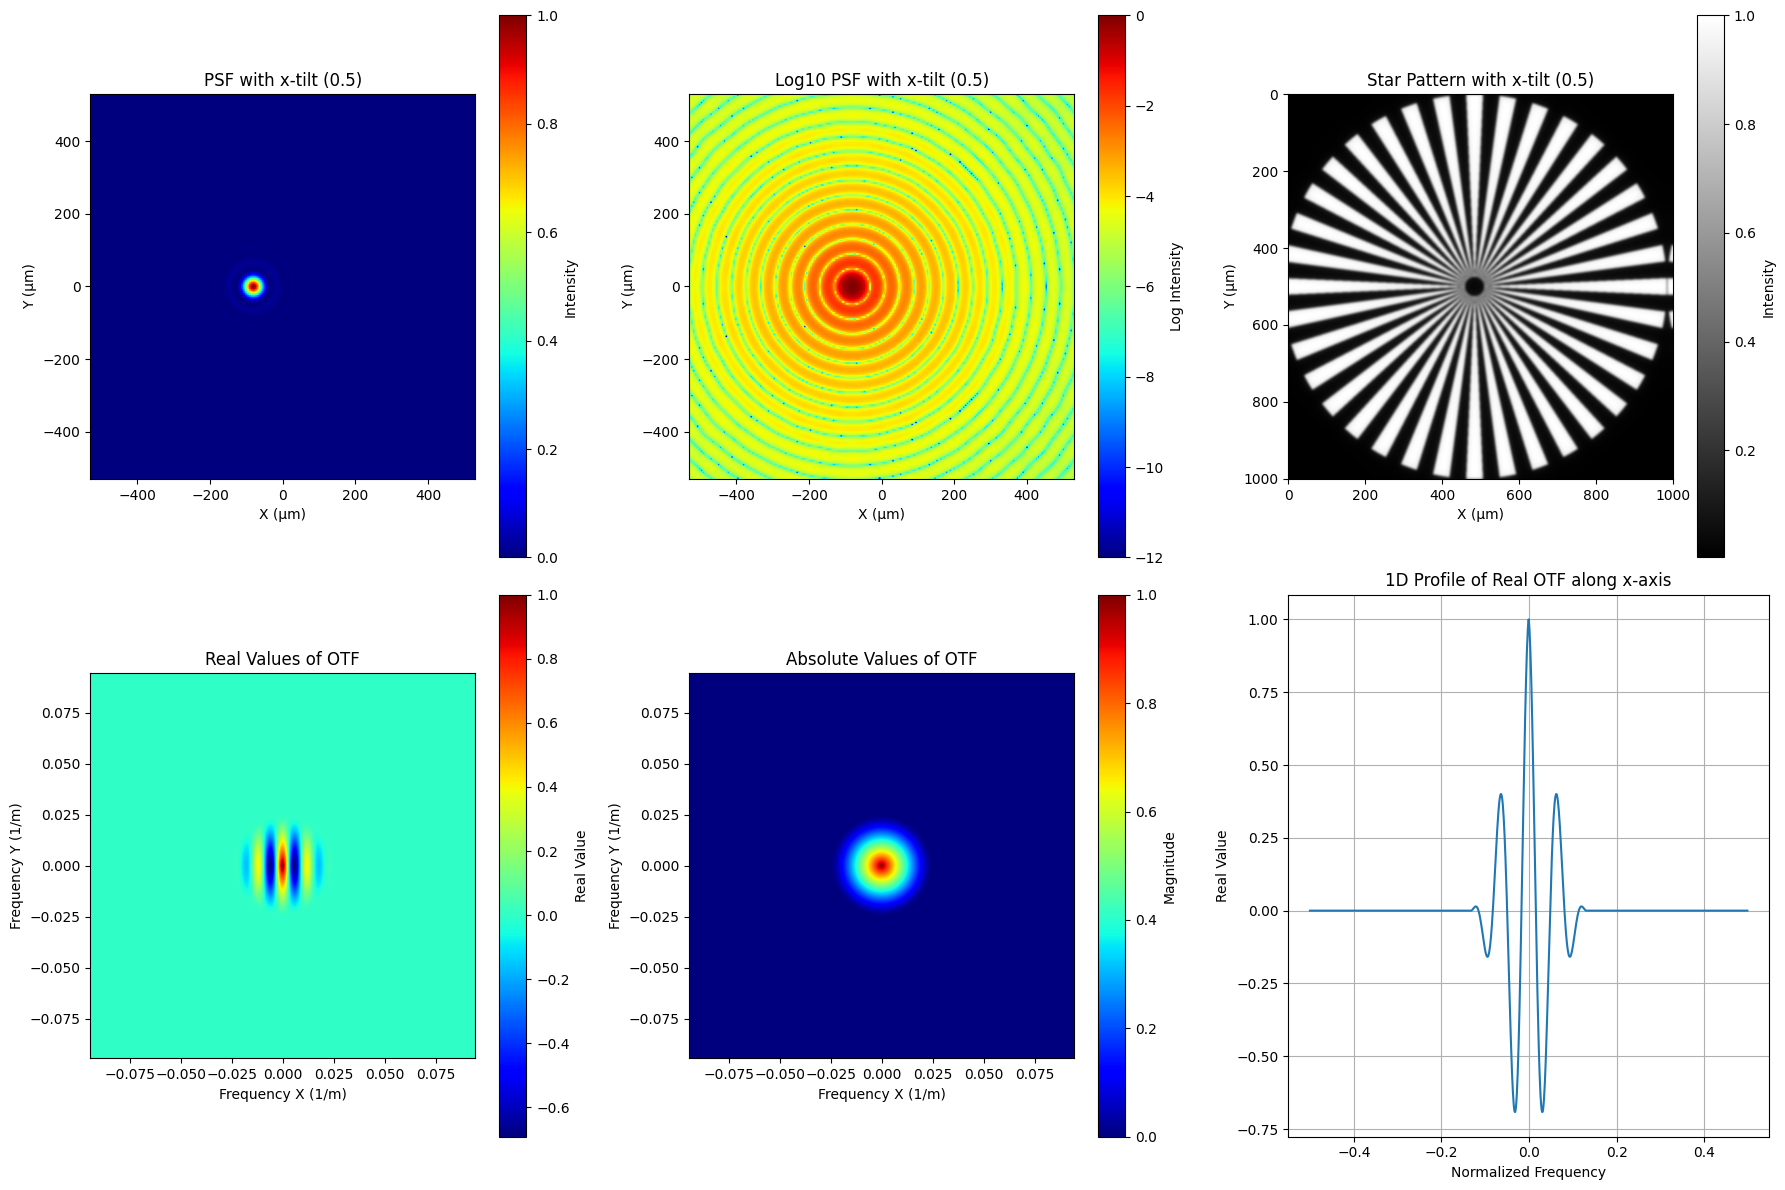

In [8]:
mode_indices = [2]
coefs = [0.5] 
title = "x-tilt (0.5)"
    
psf, OTF, star_blurred, fig = analyze_aberration(mode_indices, coefs, title, star, x, y, fx, fy, lambd=lambd_green, zi=zi, r=r, N=N)
plt.show()

This abberation results in an x-axis shift with the PSF image being shifted to the left. In the star pattern, this results in an asymmetric blur in the image which is more pronounced in the x-direction. The effect creates a stretched and slightly tilted star pattern. The OTF demonstrates how the transfer of spatial frequencies aligned with the direction of tilt are reduced.

This abberation reduces the system's resolution.

<div class="alert alert-block alert-success">
<font color=black>

2. Simulate an x-tilt of coefficient -1.3 and a y-tilt of coefficient 0.7. Show the PSF and log10 PSF, both zoomed in on the central 201 by 201 elements. Also plot the absolute value of the OTF, as well as the star pattern blurred by this system. Describe the effect of this aberration on the image and compare to the previously simulated aberration.

</font> 
</div>

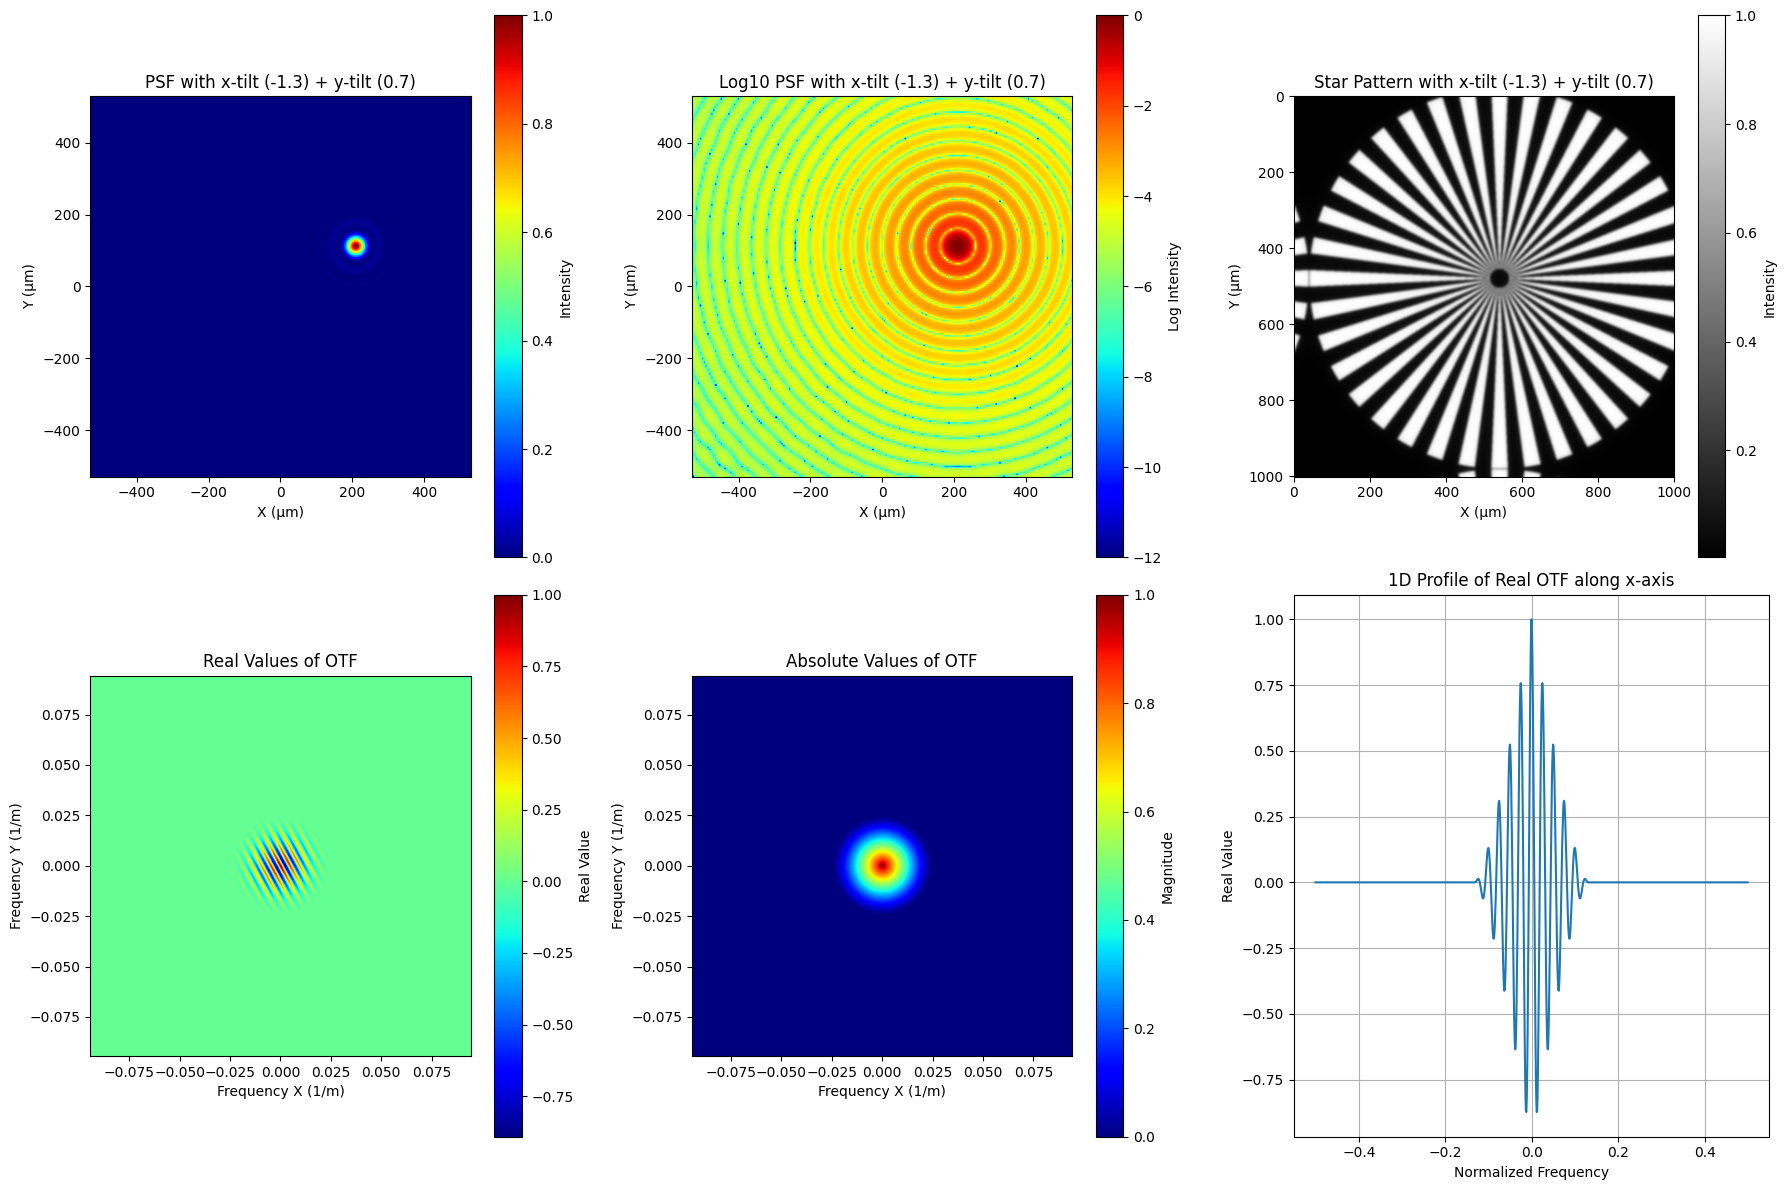

In [9]:
mode_indices = [2, 3]
coefs = [-1.3, 0.7] 
title = "x-tilt (-1.3) + y-tilt (0.7)"
    
psf, OTF, star_blurred, fig = analyze_aberration(mode_indices, coefs, title, star, x, y, fx, fy, lambd=lambd_green, zi=zi, r=r, N=N)
plt.show()

The PSF image is shifted up and to the right. With only x-tilt, the blur was elongated along the x-direction. With both x-tilt and y-tilt, the blur elongated along a diagonal and this results in an even poorer resolution due to the dual-axis distortion. This is also seen in the OTF where more spatial frequencies are being affected due to combined aberrations.

<div class="alert alert-block alert-success">
<font color=black>

3. Simulate a defocus of coefficient `1/(np.sqrt(3)*2)`, (This number represents exactly one wavelength of defocus). Show the PSF and log10 PSF, both zoomed in on the central 201 by 201 elements. Also plot the BOTH the real values and absolute values of the OTF, as well as the star pattern blurred by this system. What do you observe in the star pattern in terms of the bright and dark spokes as you go from the periphery to the center of the image? What is causing this? (Hint: look at the real-valued OTF.)

</font> 
</div>

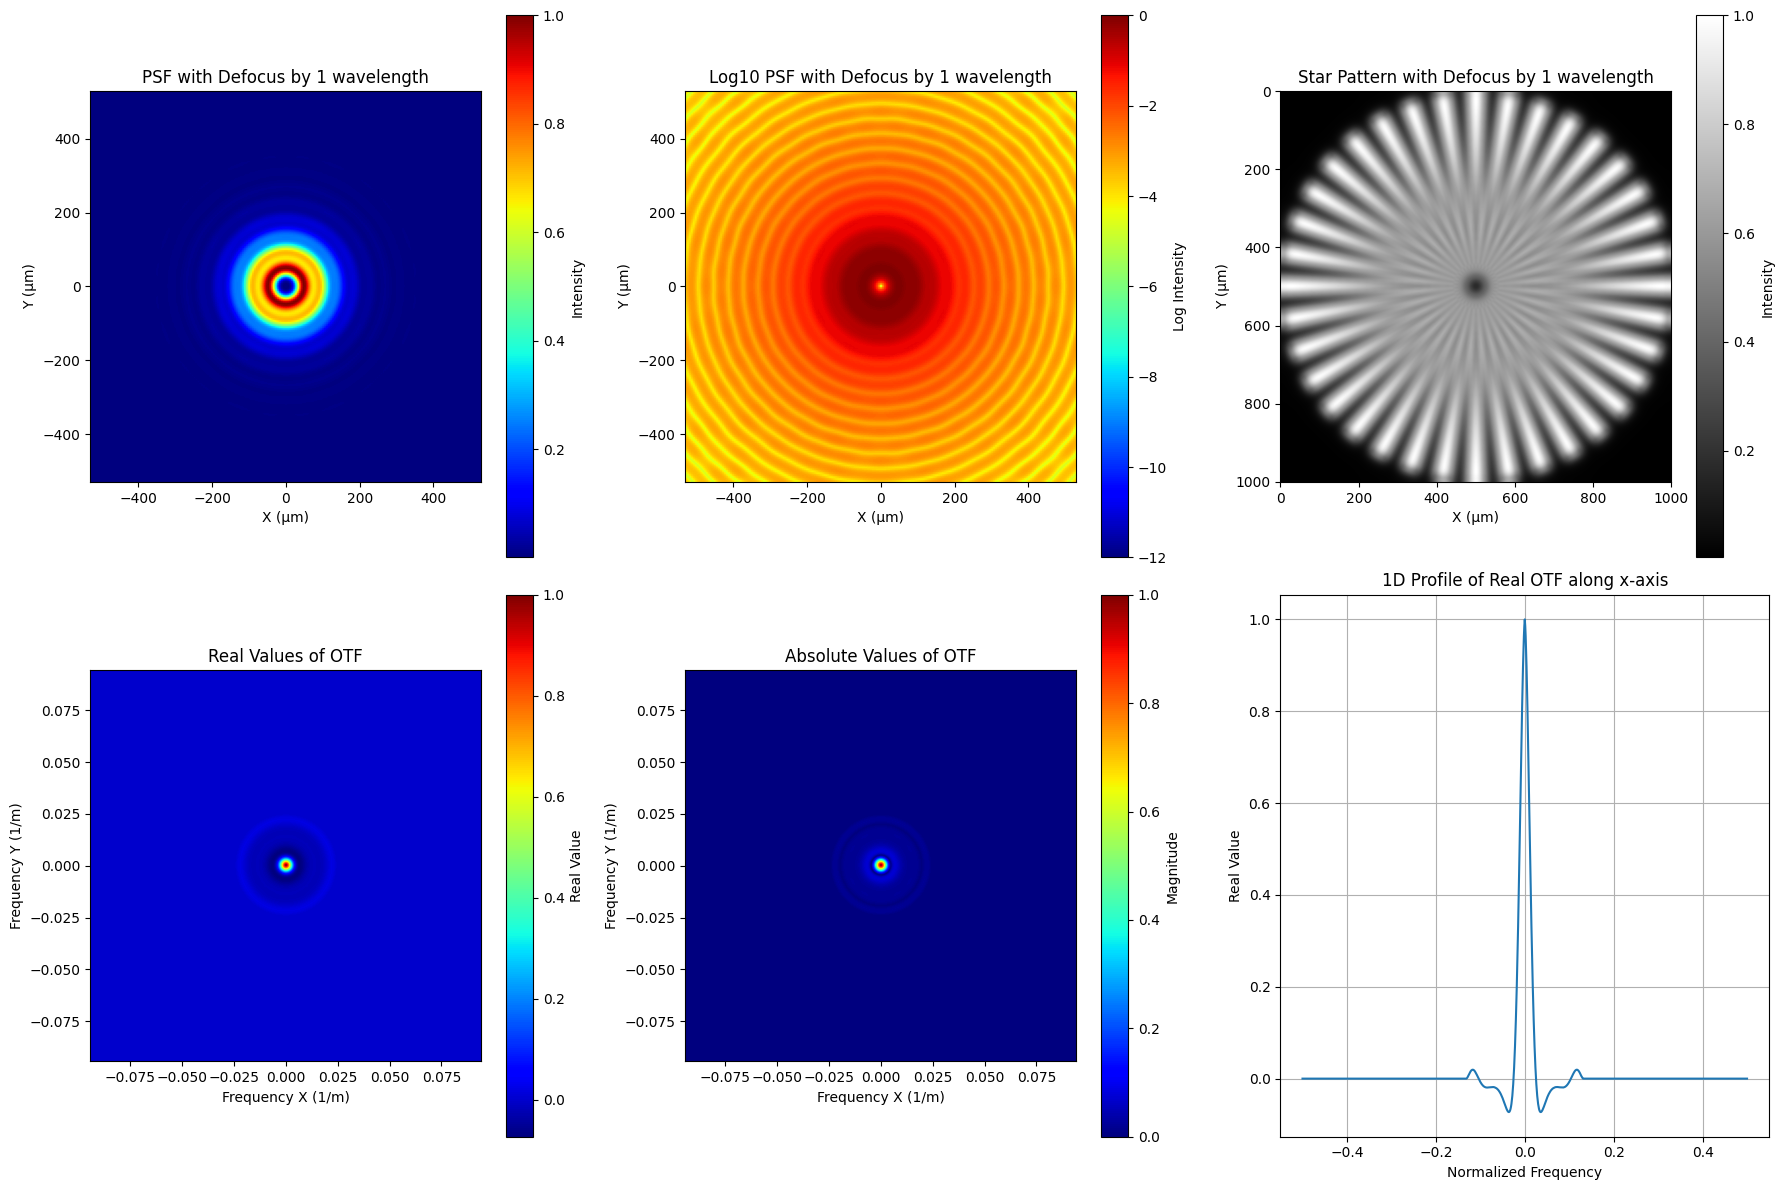

In [10]:
mode_indices = [4]  # mode 4 is defocus
coefs = [1/(np.sqrt(3)*2)]  # one wavelength of defocus
title = "Defocus by 1 wavelength"
    
psf, OTF, star_blurred, fig = analyze_aberration(mode_indices, coefs, title, star, x, y, fx, fy, lambd=lambd_green, zi=zi, r=r, N=N)
plt.show()

The PSF image shows a circular ring-like pattern with a central blur. The real-valued OTF shows a small but very bright center surrounded immediately by a very dark ring compared to the surrounding frequencies. The absolute OTF shows a more uniform distribution. The blurred star pattern shows a blur following a ring 1/2 the radius of the star pattern. The bright and dark spokes are due to the defocus aberration which introduces periodic variation in the light intensity and causes constructive and destructive interference patterns.

<div class="alert alert-block alert-success">
<font color=black>

4. Simulate a defocus of coefficient 0.5. Show the PSF and log10 PSF, both zoomed in on the central 201 by 201 elements. Also plot the real values and absolute values of the OTF, as well as the star pattern blurred by this system. Describe the effect of this aberration on the image and compare to the previous defocus simulation.

</font> 
</div>

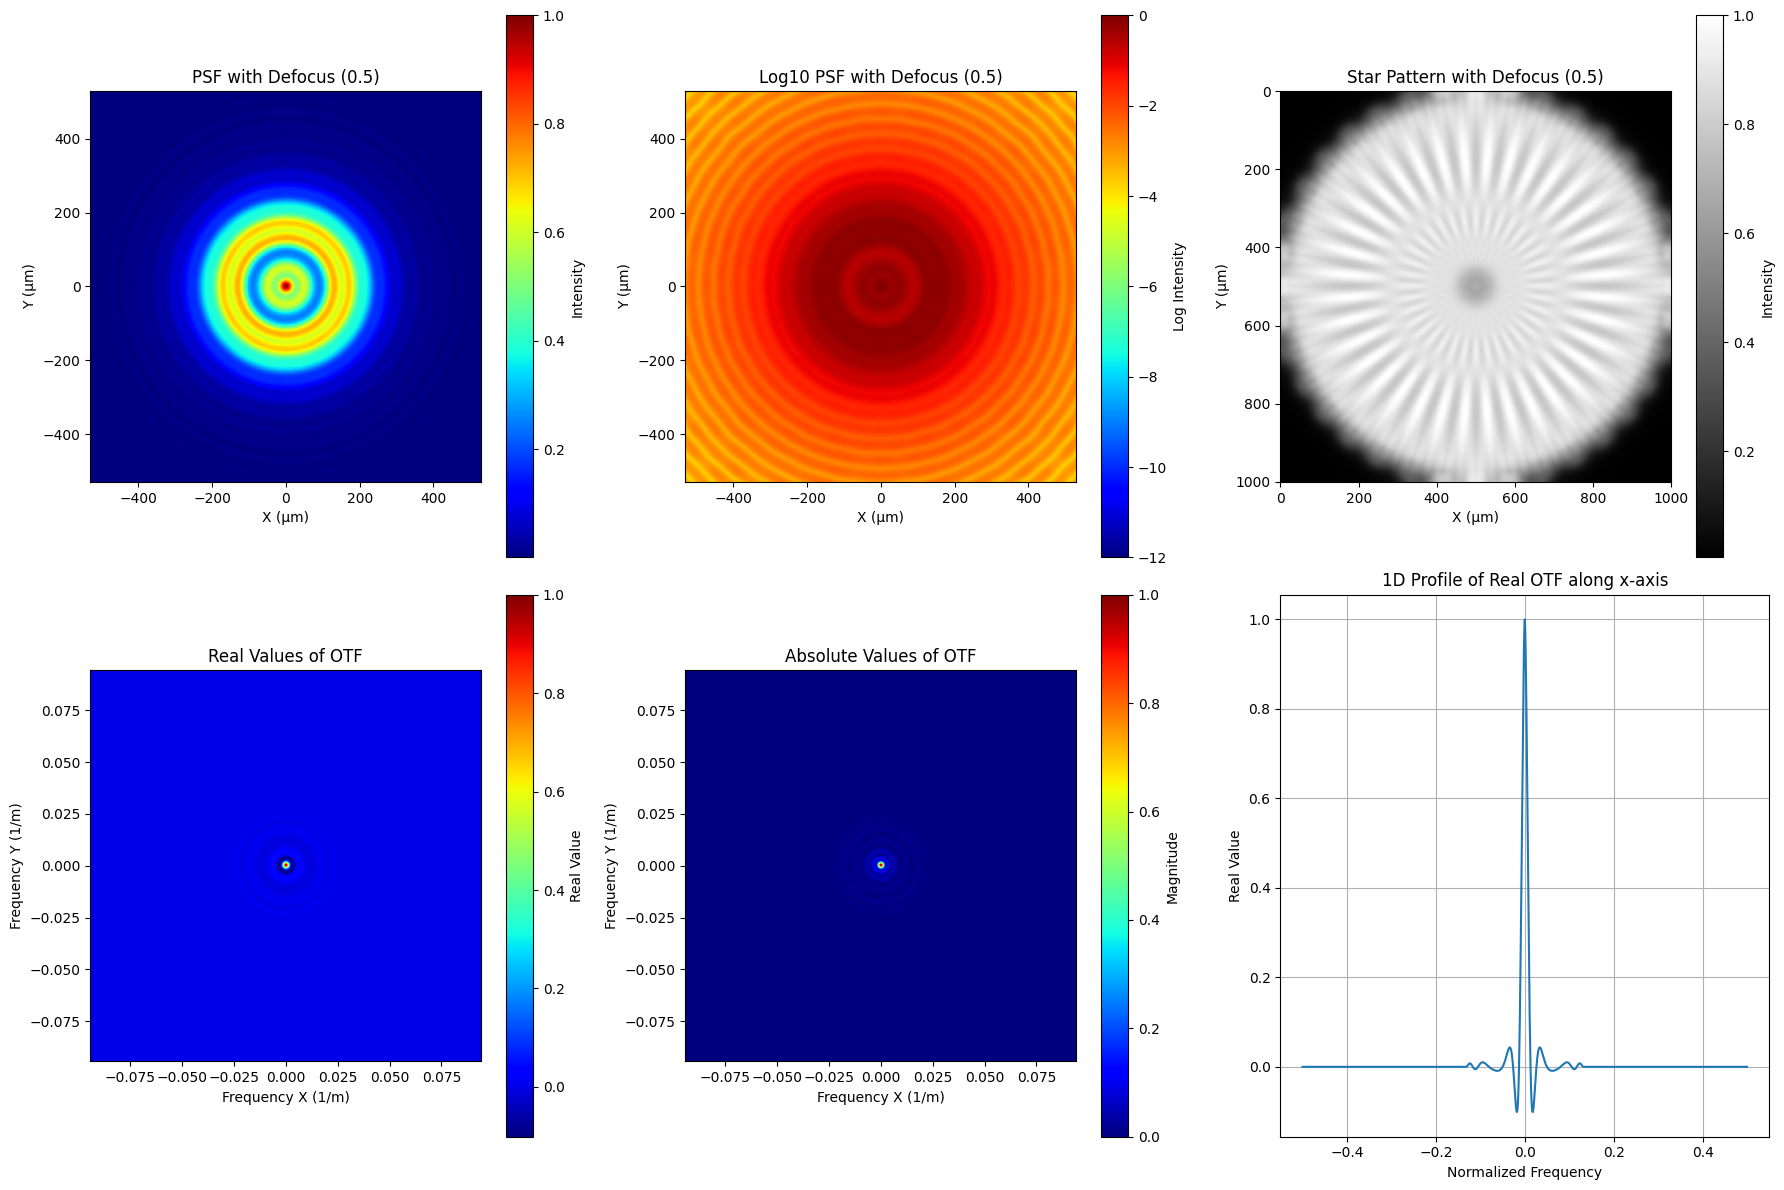

In [11]:
mode_indices = [4]  # mode 4 is defocus
coefs = [0.5]       # coefficient 0.5
title = "Defocus (0.5)"
    
psf, OTF, star_blurred, fig = analyze_aberration(mode_indices, coefs, title, star, x, y, fx, fy, lambd=lambd_green, zi=zi, r=r, N=N)
plt.show()

The PSF shows a circular blur that is more pronounced, especially at the edges of the star pattern, which can be seen. The OTF shows more pronounced spokes due to the larger defocus coefficient while the absolute OTF continues to show a more uniform distribution. The star pattern has a stronger blur with more pronounced bright and dark spots due to constructive and destructive interference compared to the previous image.

<div class="alert alert-block alert-success">
<font color=black>

5. Simulate a y-coma of coefficient 0.1. Show the PSF and log10 PSF images, both zoomed in on the central 201 by 201 elements. Also plot the real values and absolute values of the OTF, as well as the star pattern blurred by this system. Describe the effect of this aberration on the image.

</font> 
</div>

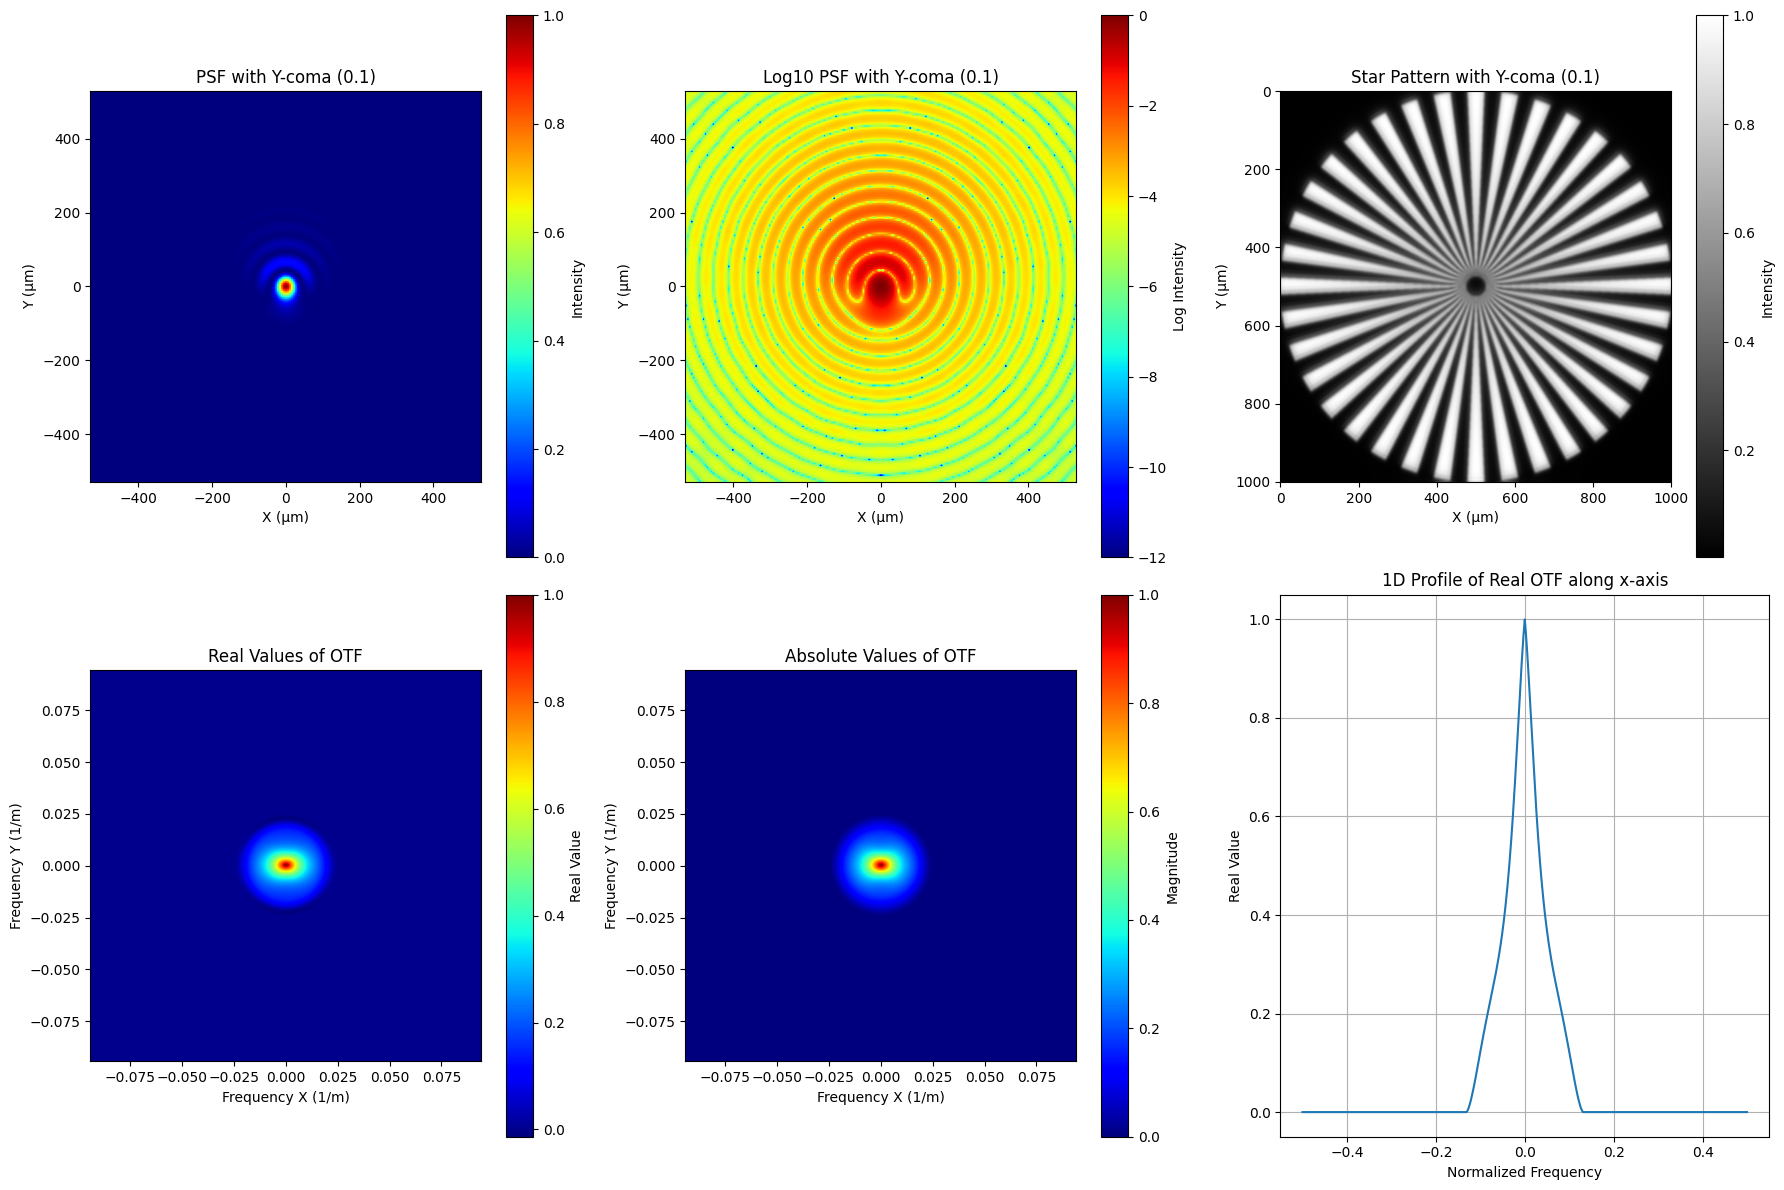

In [12]:
mode_indices = [7] 
coefs = [0.1]     
title = "Y-coma (0.1)"
    
psf, OTF, star_blurred, fig = analyze_aberration(mode_indices, coefs, title, star, x, y, fx, fy, lambd=lambd_green, zi=zi, r=r, N=N)
plt.show()

While the center of the PSF is still bright, it has an assymmetric trail in the y-direction. This is better seen in the Log10 PSF graph. The real and absolute OTF images are also asymmetric; however, they are spread out in the x-direction. Like the PSF, the star pattern is stretched along the y-axis, resulting in a loss of sharpness and lower resolution.

Compared to defocus or tilt, the coma is messier and directional as it doesn't simply blur but distorts the shape of the features.

<div class="alert alert-block alert-success">
<font color=black>

6. Simulate an x-coma of coefficient -0.2 together with a y-coma of coefficient 0.05. Show the PSF and log10 PSF images, both zoomed in on the central 201 by 201 elements. Also plot the real values and absolute values of the OTF, as well as the star pattern blurred by this system. Describe the effect of this aberration on the image and compare to the previously simulated aberration.

</font> 
</div>

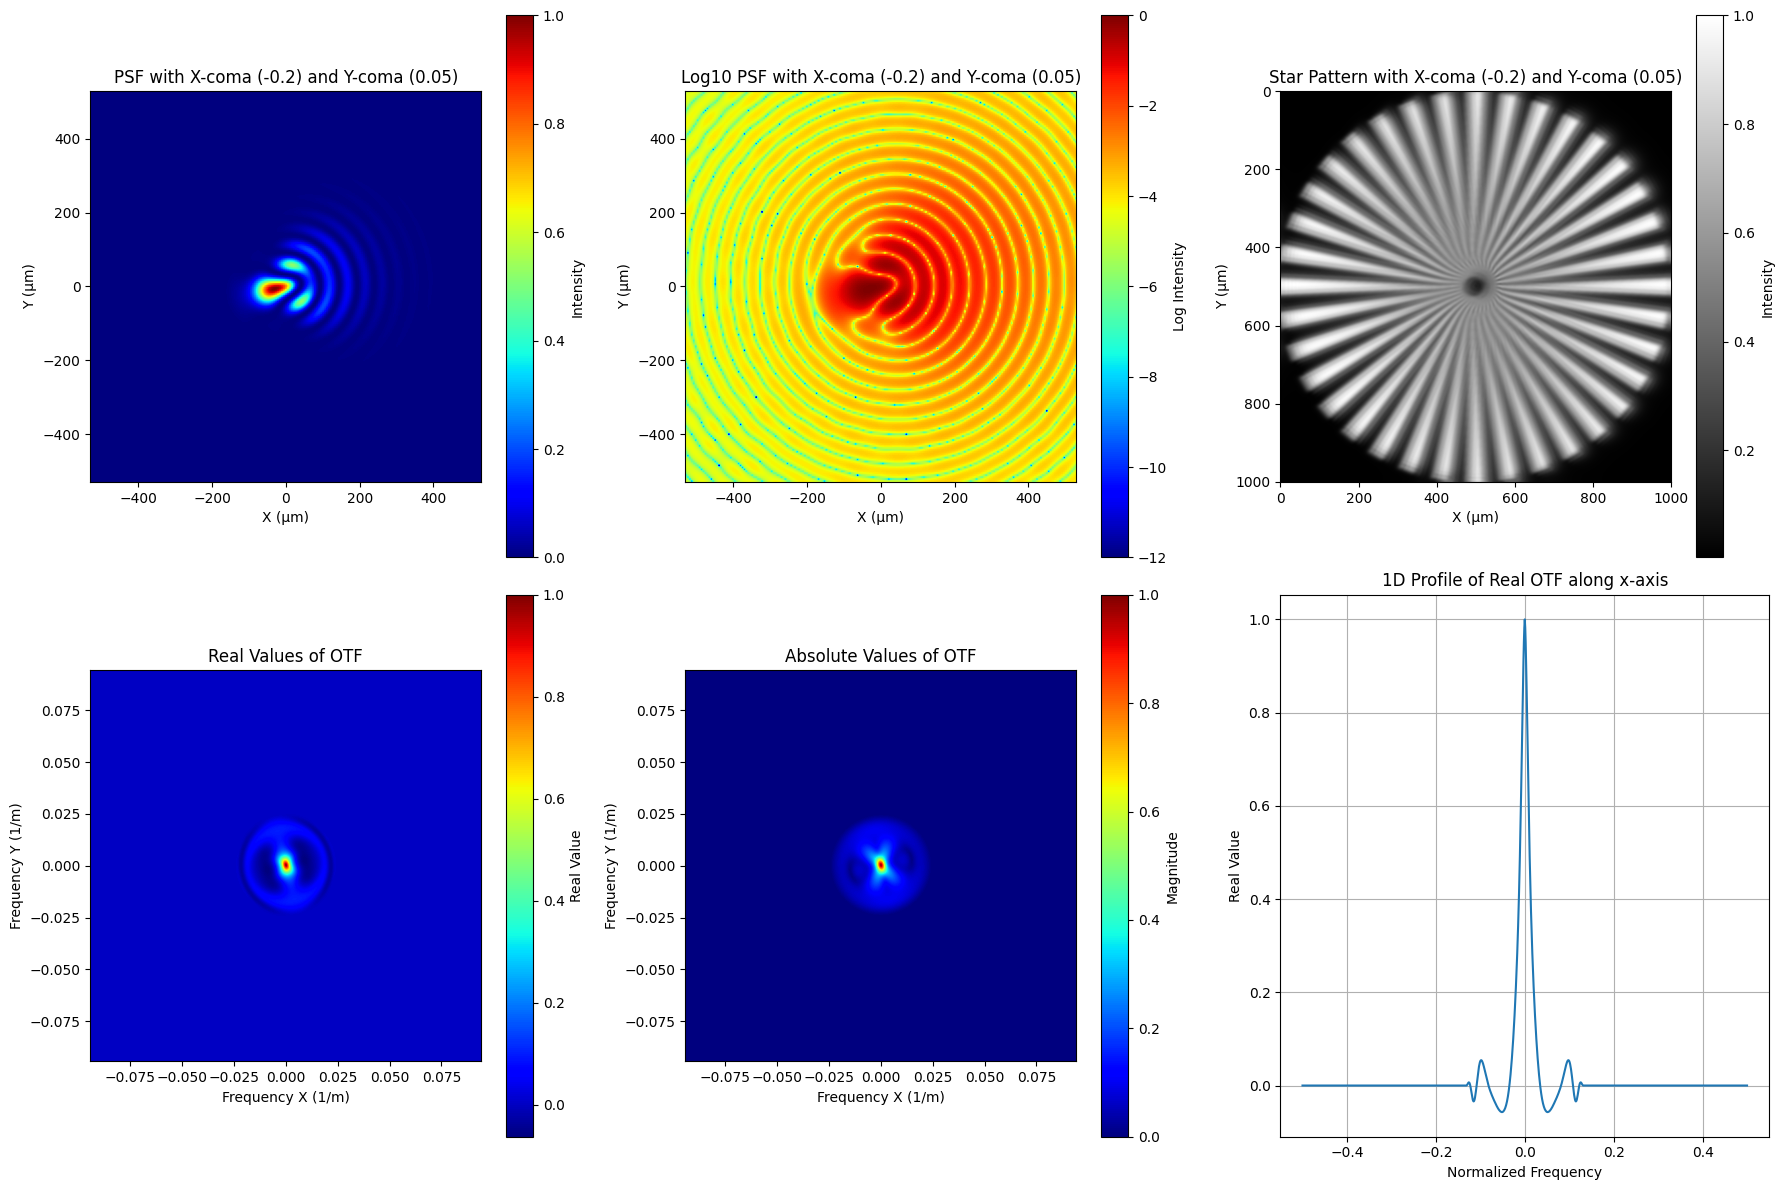

In [13]:
mode_indices = [7, 8] 
coefs = [0.05, -0.2]
title = "X-coma (-0.2) and Y-coma (0.05)"
    
psf, OTF, star_blurred, fig = analyze_aberration(mode_indices, coefs, title, star, x, y, fx, fy, lambd=lambd_green, zi=zi, r=r, N=N)
plt.show()

The PSF is now smeared diagnally, but primarily in the x-direction, which is better seen in the Log10 PSF plot. The real and absolute OTFs are lopsided but are primarily stretched perpendicular to the PSF trail direction. Along the axis of the trail there are large drops in the real and absolute values on either side of the spike. The star pattern has a much worse distortion than previous images due to the combined aberrations.

<div class="alert alert-block alert-success">
<font color=black>

7. One last simulation! Let’s look at the composition of many aberrations together. Simulate mode indices `[4, 5, 6, 7, 11]` with coefficients `[0.1, -0.2, 0.05, 0.2, 0.1]`. Show the PSF and log10 PSF images, both zoomed in on the central 201 by 201 elements. Also plot the real values and absolute values of OTF, as well as the star pattern blurred by this system. Describe the effect of this aberration on the image.

</font> 
</div>

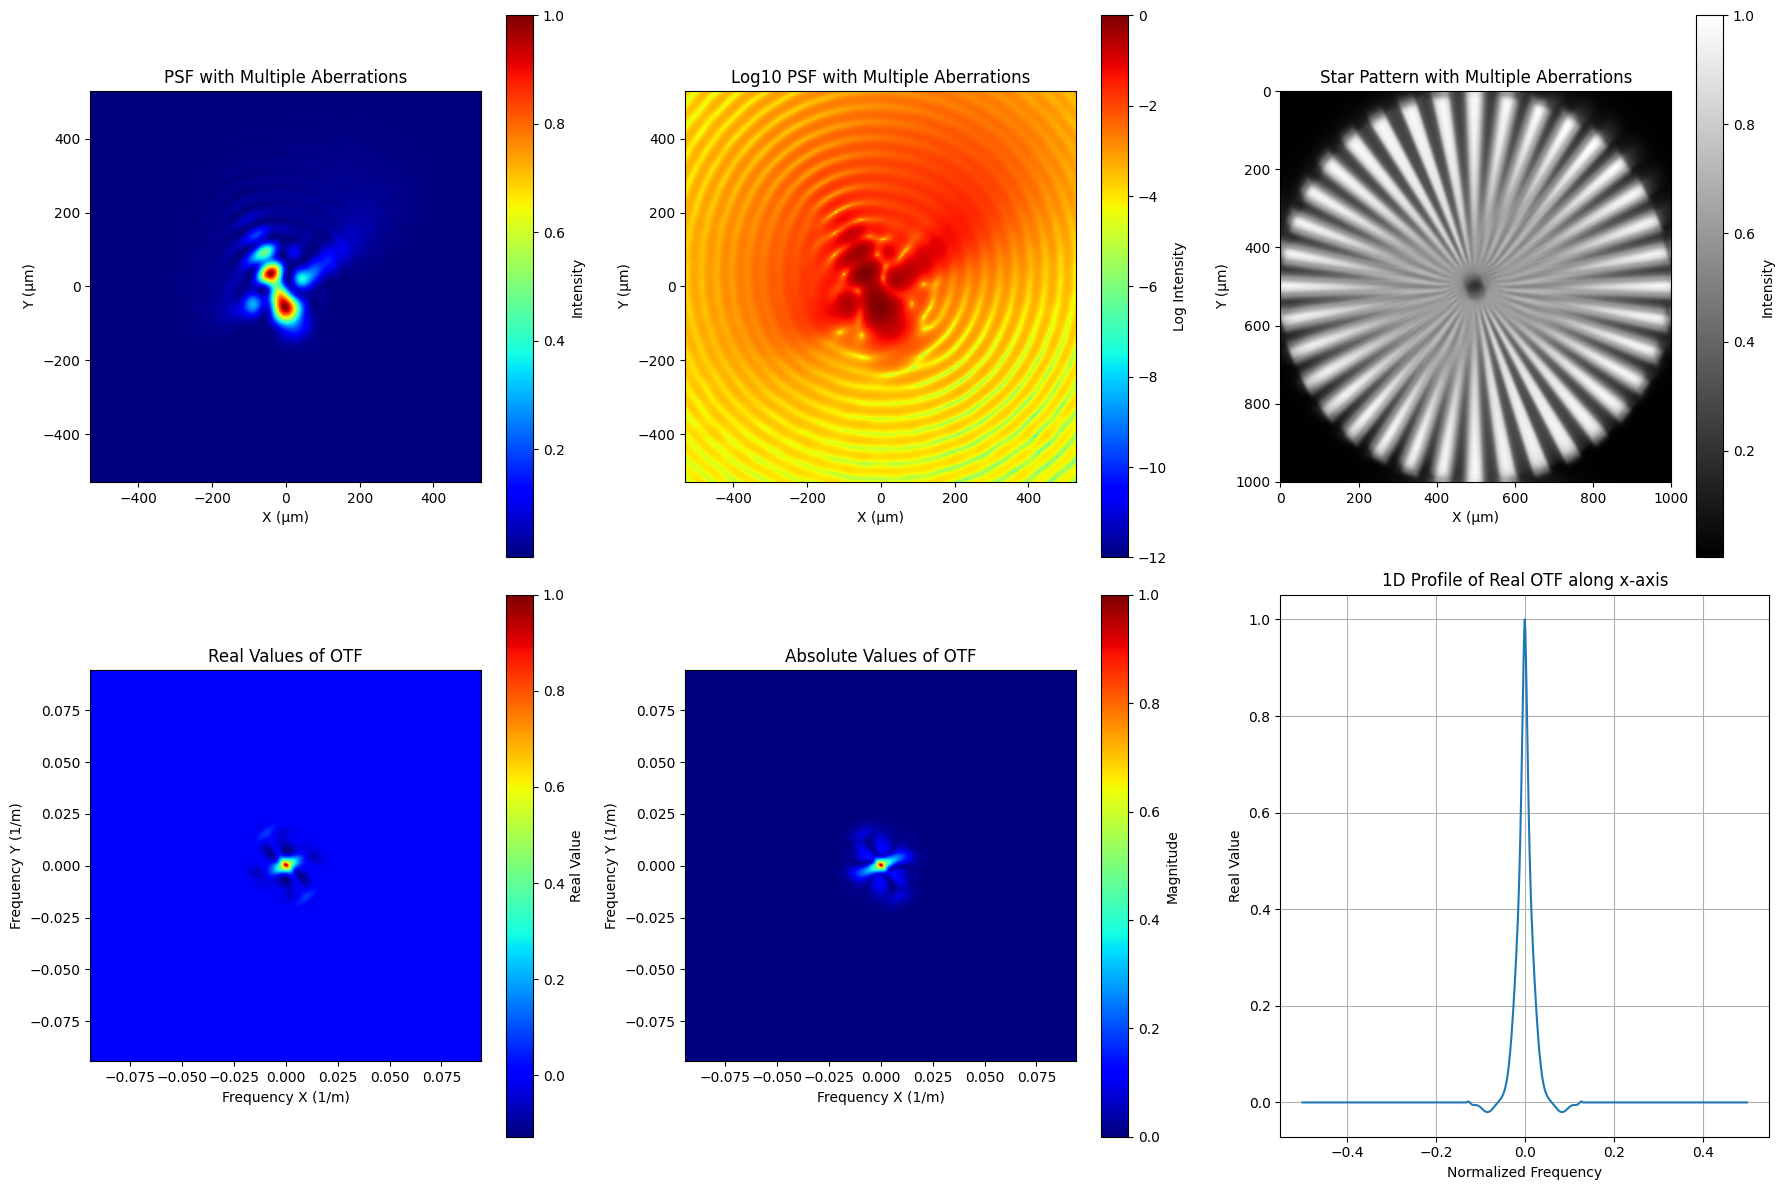

In [14]:
mode_indices = [4, 5, 6, 7, 11] 
coefs = [0.1, -0.2, 0.05, 0.2, 0.1] 
title = "Multiple Aberrations"
    
psf, OTF, star_blurred, fig = analyze_aberration(mode_indices, coefs, title, star, x, y, fx, fy, lambd=lambd_green, zi=zi, r=r, N=N)
plt.show()

Multiple abberations are stacked on this image. There is a defocus o 0.1, an oblique astigmatism of -0.2, x-coma of 0.05, y-coma of 0.2, and a spherical aberration of 0.1. This results in a significantly deformed, off-center, tilted, and asymmetric PSF which is further accentuated in the Log10 graph. The real and absolute OTFs have significant loss of symmetry. The star pattern is significantly blurred along a "butterfly"-like shape in the center.